In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

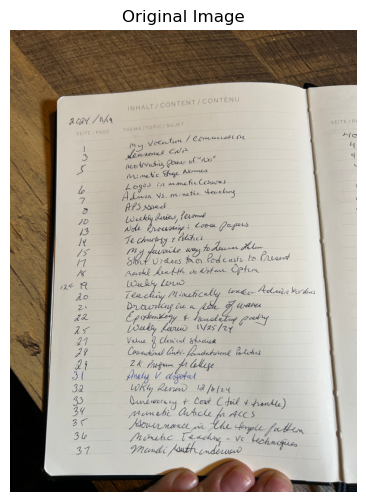

In [11]:
# --- Load image ---

input_path = "data/sample1.jpg"
img = cv2.imread(input_path)

if img is None:
    raise ValueError("Image not found. Check the input_path.")
orig = img.copy()
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(6,6))
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis("off")
plt.show()

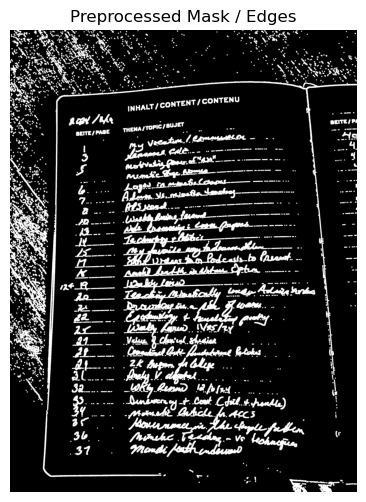

In [12]:
# --- Preprocessing ---
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# 2. Adaptive threshold to isolate document region
thresh = cv2.adaptiveThreshold(
    blurred, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    21, 15
)
# 3. Morphological closing to connect broken edges
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
# 4. Dilation to strengthen boundaries
dilated = cv2.dilate(closed, np.ones((5, 5), np.uint8), iterations=2)
# Display preprocessing result
plt.figure(figsize=(6,6))
plt.imshow(dilated, cmap='gray')
plt.title("Preprocessed Mask / Edges")
plt.axis("off")
plt.show()

⚠ No perfect 4-point contour found — using convex hull fallback.


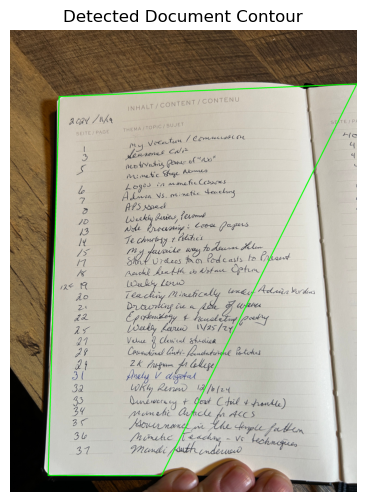

In [13]:
# ---Contour Detection ---

contours, hierarchy = cv2.findContours(
    dilated, 
    cv2.RETR_EXTERNAL,       
    cv2.CHAIN_APPROX_SIMPLE
)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
doc_cnt = None
image_area = img.shape[0] * img.shape[1]
for c in contours:
    area = cv2.contourArea(c)
    if area < 0.1 * image_area:
        continue
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    if len(approx) == 4:
        doc_cnt = approx
        break
if doc_cnt is None:
    print("⚠ No perfect 4-point contour found — using convex hull fallback.")
    hull = cv2.convexHull(contours[0])
    peri = cv2.arcLength(hull, True)
    doc_cnt = cv2.approxPolyDP(hull, 0.02 * peri, True)
    if len(doc_cnt) > 4:
        doc_cnt = doc_cnt[:4]
debug = orig.copy()
cv2.drawContours(debug, [doc_cnt], -1, (0,255,0), 8)
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(debug, cv2.COLOR_BGR2RGB))
plt.title("Detected Document Contour")
plt.axis("off")
plt.show()

In [14]:
# --- Order the contour points ---
def order_points(pts):
    pts = pts.reshape(4, 2).astype("float32")
    ordered = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    ordered[0] = pts[np.argmin(s)]  
    ordered[2] = pts[np.argmax(s)]   
    diff = np.diff(pts, axis=1)
    ordered[1] = pts[np.argmin(diff)]
    ordered[3] = pts[np.argmax(diff)]
    return ordered
pts = order_points(doc_cnt)
print("Ordered Points (TL, TR, BR, BL):")
print(pts)

Ordered Points (TL, TR, BR, BL):
[[ 428.  581.]
 [3023.  470.]
 [1319. 3890.]
 [ 332. 3887.]]


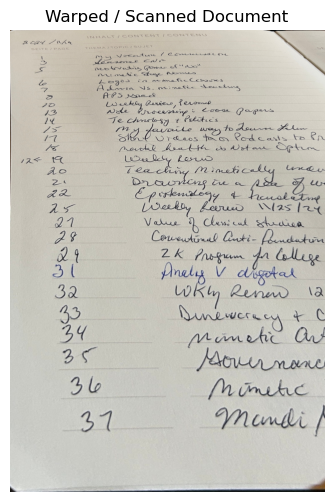

📄 Saved scanned_output.jpg!


In [15]:
# --- Perspective Transform (Warping the Document) ---

(tl, tr, br, bl) = pts
widthA = np.linalg.norm(br - bl)
widthB = np.linalg.norm(tr - tl)
maxWidth = int(max(widthA, widthB))
heightA = np.linalg.norm(tr - br)
heightB = np.linalg.norm(tl - bl)
maxHeight = int(max(heightA, heightB))
dst = np.array([
    [0, 0],
    [maxWidth - 1, 0],
    [maxWidth - 1, maxHeight - 1],
    [0, maxHeight - 1]
], dtype="float32")
M = cv2.getPerspectiveTransform(pts, dst)
warped = cv2.warpPerspective(orig, M, (maxWidth, maxHeight))
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.title("Warped / Scanned Document")
plt.axis("off")
plt.show()
cv2.imwrite("results/scanned_output.jpg", warped)
print("📄 Saved scanned_output.jpg!")

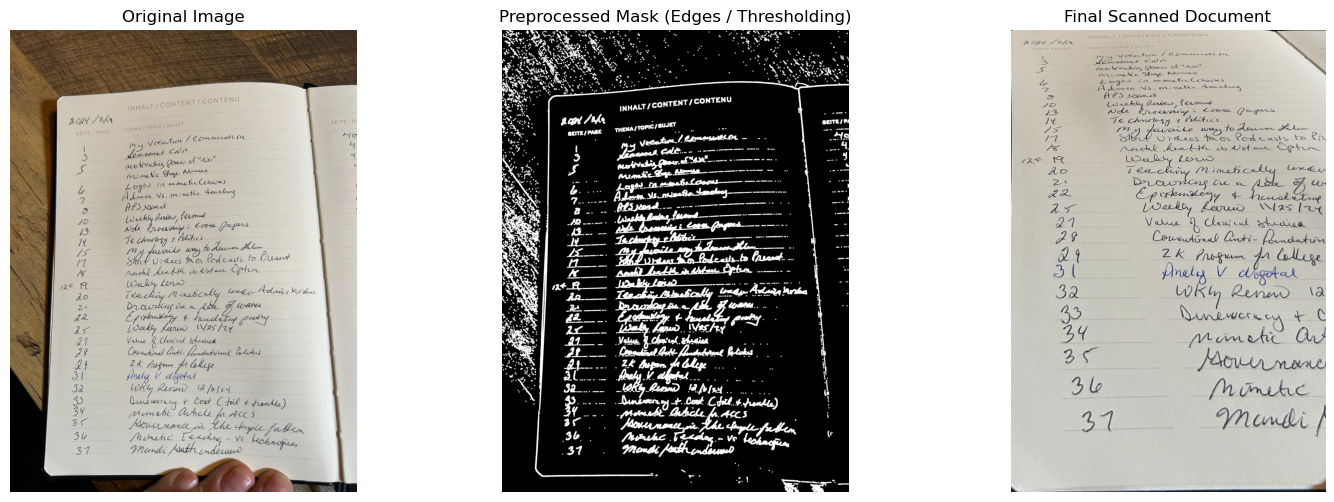

In [16]:
# --- Summary Visualization: Original, Preprocessed Mask, Scanned Result ---

plt.figure(figsize=(18,6))

# Original
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Preprocessed Mask
plt.subplot(1,3,2)
plt.imshow(dilated, cmap='gray')
plt.title("Preprocessed Mask (Edges / Thresholding)")
plt.axis("off")

# Final Scan
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.title("Final Scanned Document")
plt.axis("off")
plt.show()